In [22]:
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import pandas as pd
%matplotlib inline

2.6.0


In [14]:
model = tf.keras.models.load_model('advcnn_full.h5')

In [15]:
classes = ['background','person']

In [16]:
import pickle
with open('sample_test_images1000.pickle', 'rb') as file:
    test_generator = pickle.load(file)

In [17]:
test_images = test_generator[0]
test_labels = test_generator[1]

In [23]:
test_lab2 = []
for lab in test_labels:
  test_lab2.append(lab[1])
test_lab2[:10]

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]

In [25]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

32/32 - 17s - loss: 0.6123 - accuracy: 0.6500

Test accuracy: 0.6499999761581421


In [26]:
import math
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

In [27]:
print("size of the full model is {} bytes".format(convert_size(os.path.getsize('advcnn_full.h5'))))

size of the full model is 315.71 MB bytes


In [28]:
predictions = model.predict(test_images)
predictions[:10]

array([[0.28556812, 0.71368665],
       [0.7698356 , 0.22961944],
       [0.43995574, 0.5607057 ],
       [0.51284605, 0.4860001 ],
       [0.2648826 , 0.74507797],
       [0.8037133 , 0.19377252],
       [0.69874775, 0.2978364 ],
       [0.4605074 , 0.5326885 ],
       [0.7457198 , 0.24614927],
       [0.17517477, 0.8215667 ]], dtype=float32)

In [29]:
full_model_pred = []
full_model_pred_values = []
for pred in predictions:
  full_model_pred_values.append(pred[1])
  if pred[1] > 0.5: full_model_pred.append(1)
  else: full_model_pred.append(0)
full_model_pred[:10]

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1]

In [30]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred, full_model_pred_values)),
                          columns=['actual', 'full', 'full_vals'])
df_results.head()

,actual,full,full_vals
0,0.0,1,0.713687
1,0.0,0,0.229619
2,0.0,1,0.560706
3,0.0,0,0.486000
4,1.0,1,0.745078


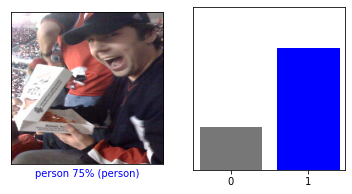

In [31]:
def plot_image(i, predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[i], cmap=plt.cm.binary)
    if predictions_array[0] > predictions_array[1]:
        pred = 0
    else: pred = 1
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    if pred == act:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(classes[pred],
                                100*np.max(predictions_array),
                                classes[act]),
                                color=color)
    
def plot_value_array(i, predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    if predictions_array[0] > predictions_array[1]:
        pred = 0
    else: pred = 1
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    thisplot[pred].set_color('red')
    thisplot[act].set_color('blue')

i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

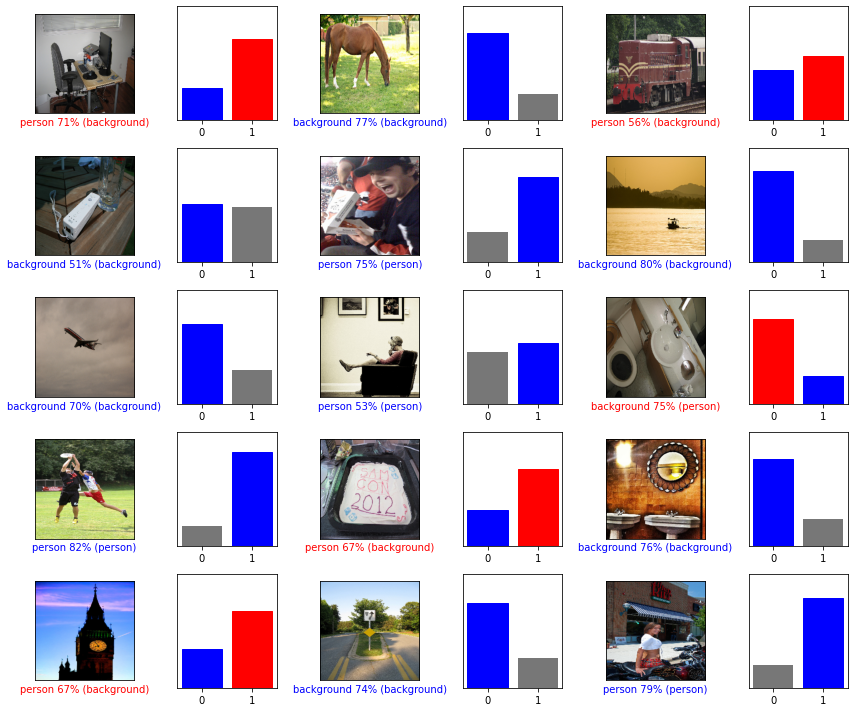

In [32]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

(250, 250, 3)
(1, 250, 250, 3)
[[0.7698356  0.22961941]]


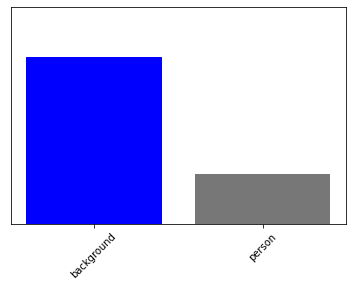

In [33]:
img = test_images[1]
print(img.shape)
img = (np.expand_dims(img,0))
print(img.shape)
predictions_single = model.predict(img)
print(predictions_single)

plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(2), classes, rotation=45)
plt.show()

Model Convertion to TensorFlow Lite model

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp81fawh__/assets


In [35]:
open("tflite_model.tflite", "wb").write(tflite_model)

110335764

Save file for models as files

In [36]:
tflite_models_dir = pathlib.Path("tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [37]:
# Save the unquantized/float TF Lite model:
tflite_model_file = tflite_models_dir/"tflite_model.tflite"
tflite_model_file.write_bytes(tflite_model)

110335764

In [38]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_lab2

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_lab2== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [39]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(test_images).batch(1).take(30):
    yield [input_value]

In [40]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


In [41]:
# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

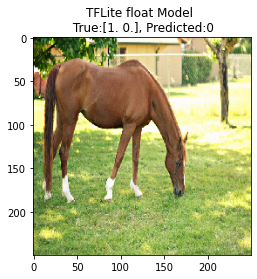

In [42]:
test_model(tflite_model_file, test_image_index, model_type="TFLite float")

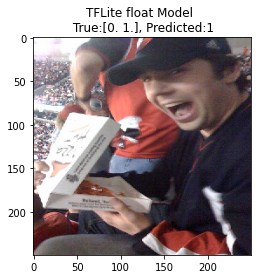

In [45]:
test_model(tflite_model_file, test_image_index=4, model_type="TFLite float")

In [46]:
evaluate_model(tflite_model_file, model_type="TFLite float")

TFLite float model accuracy is 65.0000% (Number of test samples=1000)


In [47]:
test_image_indices = range(test_images.shape[0])
pred_TFLite = run_tflite_model(tflite_model_file, test_image_indices)
pred_TFLite[:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1])

In [48]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred,full_model_pred_values, pred_TFLite )),
                          columns=['actual', 'full', 'full_vals','tflite'])
df_results.head()

,actual,full,full_vals,tflite
0,0.0,1,0.713687,1
1,0.0,0,0.229619,0
2,0.0,1,0.560706,1
3,0.0,0,0.486000,0
4,1.0,1,0.745078,1


enabled the default optimizations flag to quantize all fixed parramters such as weights

In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpz9g6s4fv/assets


INFO:tensorflow:Assets written to: /tmp/tmpz9g6s4fv/assets


In [50]:
open("tflite_model_quant.tflite", "wb").write(tflite_model_quant)

27592240

In [51]:
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('tflite_model_quant.tflite'))))

size after quanized. is 26.31 MB bytes


In [52]:
tflite_model_quant_file = tflite_models_dir/"tflite_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

27592240

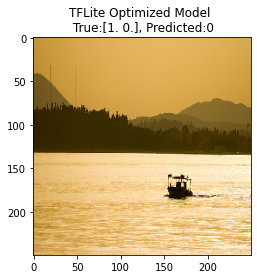

In [53]:
test_model(tflite_model_quant_file, test_image_index=5, model_type="TFLite Optimized")

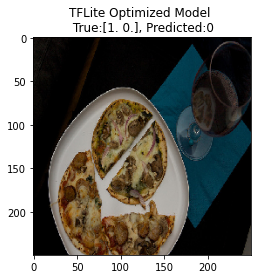

In [54]:
test_model(tflite_model_quant_file, test_image_index=16, model_type="TFLite Optimized")

In [55]:
evaluate_model(tflite_model_quant_file, model_type="TFLite float")

TFLite float model accuracy is 53.4000% (Number of test samples=1000)


In [56]:
test_image_indices = range(test_images.shape[0])
pred_TFLite_opt = run_tflite_model(tflite_model_quant_file, test_image_indices)
pred_TFLite_opt[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [57]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred,full_model_pred_values, pred_TFLite,
                                   pred_TFLite_opt)),
                          columns=['actual', 'full', 'full_vals','tflite','tflite_opt'])
df_results.head()

,actual,full,full_vals,tflite,tflite_opt
0,0.0,1,0.713687,1,0
1,0.0,0,0.229619,0,0
2,0.0,1,0.560706,1,0
3,0.0,0,0.486000,0,0
4,1.0,1,0.745078,1,0


In [58]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant_rep = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp3gednd69/assets


INFO:tensorflow:Assets written to: /tmp/tmp3gednd69/assets


In [59]:
open("tflite_model_quant_rep.tflite", "wb").write(tflite_model_quant_rep)

27592256

In [60]:
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('tflite_model_quant_rep.tflite'))))

size after quanized. is 26.31 MB bytes


In [61]:
tflite_model_quant_rep_file = tflite_models_dir/"tflite_model_quant_rep.tflite"
tflite_model_quant_rep_file.write_bytes(tflite_model_quant_rep)

27592256

In [62]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_rep)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


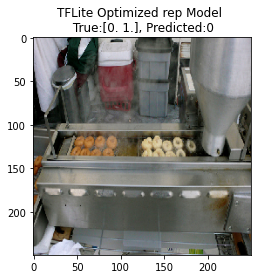

In [63]:
test_model(tflite_model_quant_rep_file, test_image_index=30, model_type="TFLite Optimized rep")

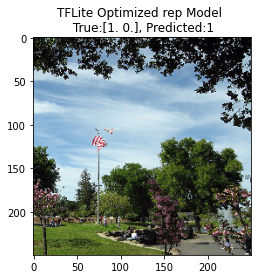

In [64]:
test_model(tflite_model_quant_rep_file, test_image_index=31, model_type="TFLite Optimized rep")

In [65]:
evaluate_model(tflite_model_quant_rep_file, model_type="TFLite optim rep")

TFLite optim rep model accuracy is 65.1000% (Number of test samples=1000)


In [66]:
pred_TFLite_opt_rep = run_tflite_model(tflite_model_quant_rep_file, test_image_indices)
pred_TFLite_opt_rep[:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1])

In [67]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred,full_model_pred_values, pred_TFLite,
                                   pred_TFLite_opt, pred_TFLite_opt_rep)),
                          columns=['actual', 'full', 'full_vals','tflite','tflite_opt',
                                   'tflite_opt_rep'])
df_results.head()

,actual,full,full_vals,tflite,tflite_opt,tflite_opt_rep
0,0.0,1,0.713687,1,0,1
1,0.0,0,0.229619,0,0,0
2,0.0,1,0.560706,1,0,1
3,0.0,0,0.486000,0,0,0
4,1.0,1,0.745078,1,0,1


In [68]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int8 = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpeu2uber8/assets


INFO:tensorflow:Assets written to: /tmp/tmpeu2uber8/assets


In [69]:
open("tflite_int8.tflite", "wb").write(tflite_int8)
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('tflite_int8.tflite'))))

size after quanized. is 26.31 MB bytes


In [70]:
tflite_int8_file = tflite_models_dir/"tflite_int8.tflite"
tflite_int8_file.write_bytes(tflite_int8)

27592328

In [71]:
interpreter = tf.lite.Interpreter(model_content=tflite_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


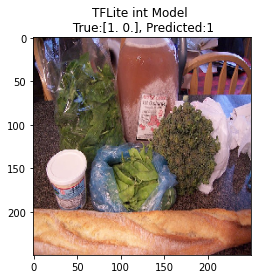

In [74]:
test_model(tflite_int8_file, test_image_index=35, model_type="TFLite int")

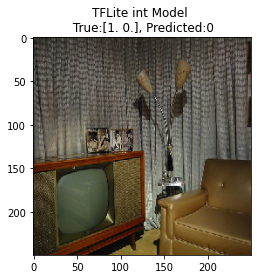

In [75]:
test_model(tflite_int8_file, test_image_index=36, model_type="TFLite int")

In [76]:
evaluate_model(tflite_int8_file, model_type="TFLite int")

TFLite int model accuracy is 65.1000% (Number of test samples=1000)


In [77]:
pred_TFLite_int = run_tflite_model(tflite_int8_file, test_image_indices)
pred_TFLite_int[:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1])

In [78]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred,full_model_pred_values, pred_TFLite,
                                   pred_TFLite_opt, pred_TFLite_opt_rep, pred_TFLite_int)),
                          columns=['actual', 'full', 'full_vals','tflite','tflite_opt',
                                   'tflite_opt_rep', 'tflite_int'])
df_results.head()

,actual,full,full_vals,tflite,tflite_opt,tflite_opt_rep,tflite_int
0,0.0,1,0.713687,1,0,1,1
1,0.0,0,0.229619,0,0,0,0
2,0.0,1,0.560706,1,0,1,1
3,0.0,0,0.486000,0,0,0,0
4,1.0,1,0.745078,1,0,1,1


In [79]:
df_results.to_csv('results_1000.csv')